# 演習3-4 自己符号化器による特徴表現の獲得

ここでは自己符号化器（オートエンコーダ）に基づく教師なし学習を考えてみます．
オートエンコーダは，入力と出力のペアを学習するモデルではありますが，入出力のペアには全く同じデータを与えるところに特徴があります．
ある入力を与えたときに，入力と同じ出力を出すネットワークに意味があるのかという話になりますが，その中間表現には意味が出てきます．
例えば中間層の次元を絞ったモデルでうまく学習できたときには，絞った次元でデータを表現し，その表現を使うともとのパターンを復元するだけの情報を持っているという
ことになりますから，データに依存した次元圧縮が可能になっていると捉えることができます．

ここでは，

1. オートエンコーダによる MNIST の潜在表現の分析
2. 変分オートエンコーダ(VAE) によるデータの生成と分析

について考えたいと思います．

## オートエンコーダの構成

最初にオートエンコーダを考えたいと思います．このネットワークは符号化器(エンコーダ: encoder) と復号器(デコーダ: decoder) を組み合わせたモデルと考えることができます．
このエンコーダとデコーダの接合部分が潜在表現となります．
もでるとしてつくると下記のようなモデルとなります．

In [15]:
# シンプルなオートエンコーダの構築
import torch
import torch.nn as nn

# オートエンコーダモデル
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

ここでは MNIST を取り扱うために エンコーダとデコーダ，それぞれのネットワーク構成を

- エンコーダ: 784-128-32-2
- デコーダ: 2-32-128-784

という対象になるようなモデル構成で考え，それぞれの層に非線形関数である `ReLU()` と `Sigmoid()` を設定しています．デコーダの最終層の非線形関数をシグモイド関数に設定しているのは，もとの MNIST のデータセットが [0, 1] の区間で定義されたデータであることに由来しています．

## データセットの準備と学習

このモデルに `MNIST` データセットを学習させることを考えます．
まずはデータセットを準備します．

In [ ]:
# データセット準備
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# 1. データセットの前処理設定
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 28x28 を 784次元に平坦化
])

# MNIST データセットの読み込み
mnist_train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_train_dataset, batch_size=128, shuffle=True)

次に学習させます．学習は，クラス判別とはことなり，自分との違いが損失関数となりますので，`nn.MSELoss()` 関数を使います．
学習は `SGD` を使っても良いのですが，ここでは時間短縮のため `Adam` と呼ばれる方法を取ります．

Epoch [1/20], Loss: 0.0005
Epoch [2/20], Loss: 0.0004
Epoch [3/20], Loss: 0.0004
Epoch [4/20], Loss: 0.0004
Epoch [5/20], Loss: 0.0004
Epoch [6/20], Loss: 0.0003
Epoch [7/20], Loss: 0.0003
Epoch [8/20], Loss: 0.0003
Epoch [9/20], Loss: 0.0003
Epoch [10/20], Loss: 0.0003
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0003
Epoch [13/20], Loss: 0.0003
Epoch [14/20], Loss: 0.0003
Epoch [15/20], Loss: 0.0003
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0003


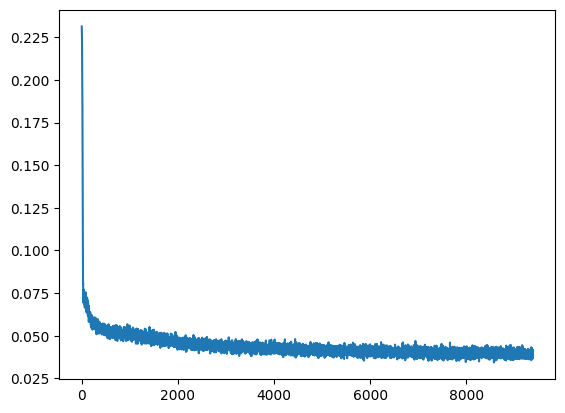

In [25]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデル定義
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
history = []
# モデル学習
for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        _, decoded = model(x)
        loss = criterion(decoded, x)
        history.append(loss.item())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader.dataset):.4f}")

plt.plot(history)


無事に学習できているようなので中間層の表現を眺めていきます．
中間層の表現を得るには，モデルのエンコーダ部分を収集します．

In [13]:
encoded_data = []
labels = []

with torch.no_grad():
    for x, targets in dataloader:
        x = x.to(device)
        encoded, _ = model(x)  # エンコードされた値を取得
        encoded_data.append(encoded.cpu())
        labels.append(targets)

encoded_data = torch.cat(encoded_data)  # 全データを結合
labels = torch.cat(labels)

最後に集めたデータは，２次元のデータなので，これをラベルとともに散布図とします．

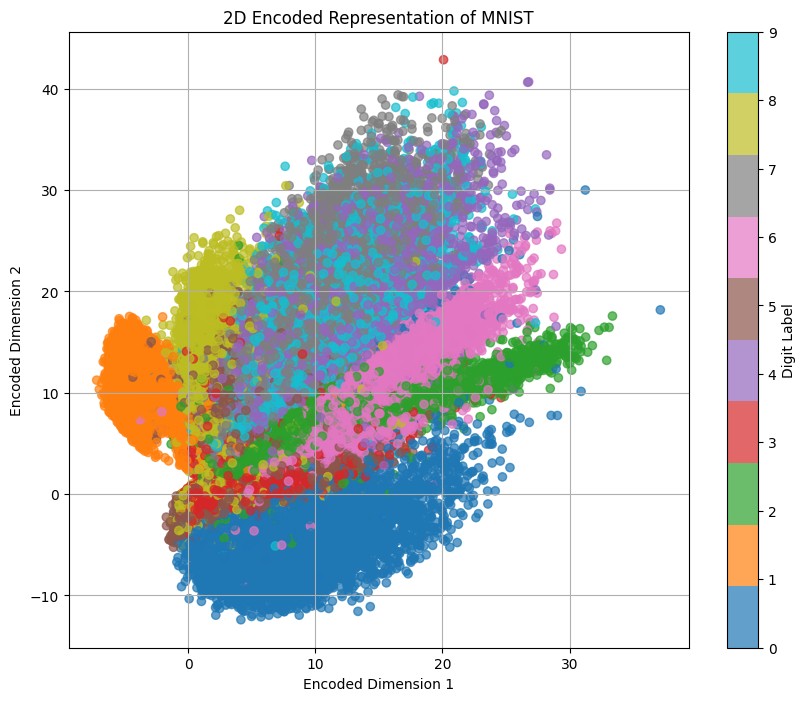

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.title('2D Encoded Representation of MNIST')
plt.grid(True)


## 変分自己符号化器(VAE)

変分自己符号化器（Variational Auto Encoder: VAE）は，AEの亜種で，潜在表現を既知の確率分布で表すことができるようにしたモデルです．
潜在表現を既知の確率分布（通常は多次元正規分布）に表現させようとすることにしているため，逆に潜在空間の上で，その分布に基づいた乱数をふることで
乱数からデータを生成させることができるようになります．
これに基づいて画像などのデータ生成をさせるというのがVAEの主たる使い方になります．（Diffusion モデルのご先祖だと思ってもらっても良いです）

モデル構成は下記の通りになります．
ここでは潜在空間は２次元の空間となるので２次元の正規分布が間にはさまるような形になっていると思ってもらって大丈夫です．
符号化器を正規分布化するために，中心パラメータを制御する `fc_mu` と分散を制御する `fc_logvar` が付け加えられています．

`reparameterize()` 関数は，ネットワークの中心で正規分布化するための関数で，ここのなかで乱数を生成させ，デコードさせることで新奇なパターンをどんどん生成させることができるようにします．
（この生成方法はリパラメトリゼーショントリックと呼ばれます）
したがって，学習時にはこの正規分布がどこにあるのかを獲得する必要が出てきます．
このため `forward()` 関数では，復号化したデータ以外にも，分布の中心 `mu` と `logvar` を返すような形になります．

In [21]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder: 潜在空間の平均と標準偏差を出力
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, 2)       # 平均 μ
        self.fc_logvar = nn.Linear(32, 2)  # 対数分散 log(σ^2)

        # Decoder: 潜在空間からデータを再構成
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # 再パラメータ化トリック
        std = torch.exp(0.5 * logvar)  # 標準偏差
        epsilon = torch.randn_like(std)  # 標準正規分布からサンプリング
        return mu + std * epsilon

    def forward(self, x):
        # エンコーダ
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        
        # 再パラメータ化
        z = self.reparameterize(mu, logvar)
        
        # デコーダ
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

学習では，復号データと入力データの差分だけではなく，符号化データが与えた確率分布に従っているように細工が必要となります．このため，単純な再構成誤差だけでなく，KLダイバージェンスと呼ばれる項を損失関数に追加します．

In [ ]:
import torch.optim as optim

def vae_loss(reconstructed, x, mu, logvar):
    # 再構成損失 (MSE または BCE)
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, x, reduction='sum')
    
    # KLダイバージェンス
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reconstruction_loss + kl_divergence


# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルと最適化器の準備
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# 学習ループ
num_epochs = 20
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch, (x, _) in enumerate(dataloader):
        x = x.to(device)
        
        # 順伝播
        reconstructed, mu, logvar = vae(x)
        
        # 損失計算
        loss = vae_loss(reconstructed, x, mu, logvar)
        
        # 逆伝播とパラメータ更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader.dataset):.4f}")



Epoch [1/20], Loss: 207.6560
Epoch [2/20], Loss: 174.5054
Epoch [3/20], Loss: 166.9409
Epoch [4/20], Loss: 162.9294
Epoch [5/20], Loss: 160.1647
Epoch [6/20], Loss: 157.9227
Epoch [7/20], Loss: 156.2345
Epoch [8/20], Loss: 154.9339
Epoch [9/20], Loss: 153.8787
Epoch [10/20], Loss: 152.8749
Epoch [11/20], Loss: 152.0195
Epoch [12/20], Loss: 151.6123
Epoch [13/20], Loss: 150.8387
Epoch [14/20], Loss: 150.2503
Epoch [15/20], Loss: 149.8122
Epoch [16/20], Loss: 149.3475
Epoch [17/20], Loss: 148.7866
Epoch [18/20], Loss: 148.4715
Epoch [19/20], Loss: 148.0851
Epoch [20/20], Loss: 147.4928


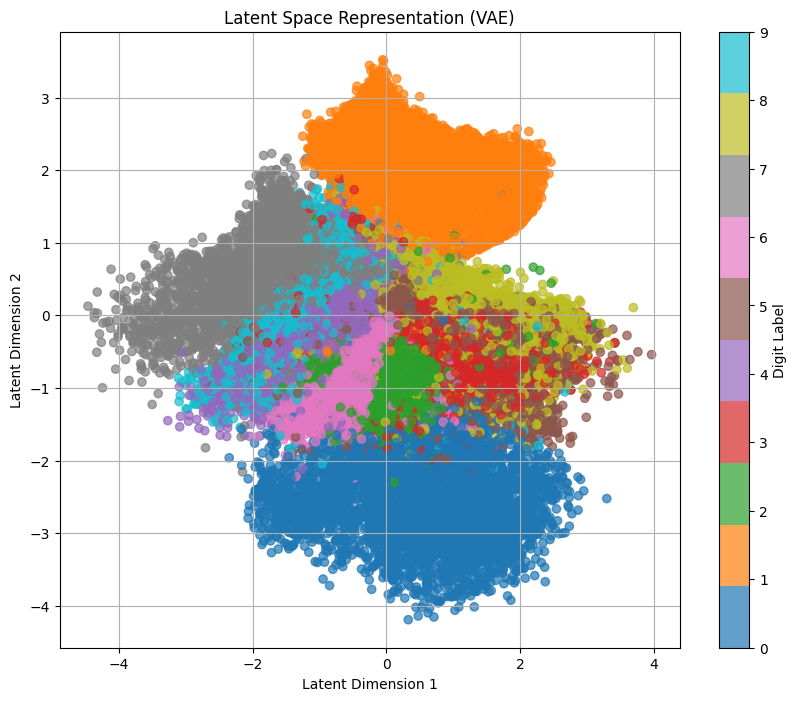

In [26]:
vae.eval()
encoded_data = []
labels = []

with torch.no_grad():
    for x, y in dataloader:
        x = x.to(device)
        _, mu, _ = vae(x)  # 平均値を潜在変数として使用
        encoded_data.append(mu.cpu())
        labels.append(y)

encoded_data = torch.cat(encoded_data)
labels = torch.cat(labels)

# 散布図のプロット
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation (VAE)')
plt.grid(True)
plt.show()

それでは，２次元の潜在空間上で適当な２点を選んで線分を構成し，その線上のデータがどのようなデータに再構成されるかを眺めてみましょう．

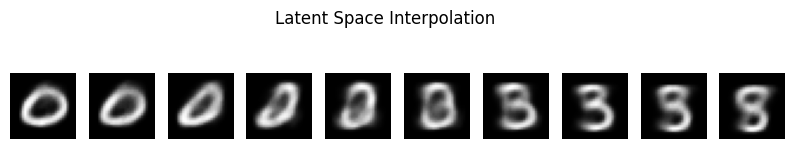

In [36]:
# 2つの潜在ベクトル間を補間
z1 = torch.randn(1, 2).to(device)  # 潜在ベクトル1
z2 = torch.randn(1, 2).to(device)  # 潜在ベクトル2
interpolated_z = torch.linspace(0, 1, steps=10).unsqueeze(1) * z1 + (1 - torch.linspace(0, 1, steps=10).unsqueeze(1)) * z2

# データ生成
vae.eval()
with torch.no_grad():
    interpolated_images = vae.decoder(interpolated_z)

# 可視化
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(interpolated_images[i].view(28, 28).cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Latent Space Interpolation')
plt.show()

## 演習 3-4

1. AE, VAE から得られた潜在空間表現に k-meas 法を施し，どのようなクラスタが得られるかを図示しなさい．
2. AE, VAE の構成に畳み込み演算を入れた場合，潜在空間がどのようになるかを図示しなさい．
3. `Fashion-MNIST` と `CIFAR10` の潜在空間表現がどのようになるかを図示しなさい．